<a href="https://colab.research.google.com/github/Sababa123/LA-Crime-Data/blob/main/LA-Crime-Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, mean_squared_error, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from calendar import day_name
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Projects-Datacamp/LA-Crime-Data/crimes.csv')

## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247988 entries, 0 to 247987
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DR_NO         247988 non-null  int64 
 1   Date Rptd     247988 non-null  object
 2   DATE OCC      247988 non-null  object
 3   TIME OCC      247988 non-null  int64 
 4   AREA NAME     247988 non-null  object
 5   Crm Cd Desc   247988 non-null  object
 6   Vict Age      247988 non-null  int64 
 7   Vict Sex      215740 non-null  object
 8   Vict Descent  215739 non-null  object
 9   Weapon Desc   80087 non-null   object
 10  Status Desc   247988 non-null  object
 11  LOCATION      247988 non-null  object
dtypes: int64(3), object(9)
memory usage: 22.7+ MB


In [5]:
# Detect and parse date column
date_cols = [c for c in df.columns if 'DATE' in c.upper()]
date_col = date_cols[0]
df['Date'] = pd.to_datetime(df[date_col], errors='coerce')

In [6]:
# Extract time-based features
time_col = 'TIME OCC' if 'TIME OCC' in df.columns else [c for c in df.columns if 'TIME' in c.upper()][0]
df[time_col] = df[time_col].astype(str).str.zfill(4)
df['Hour'] = pd.to_datetime(df[time_col], format='%H%M', errors='coerce').dt.hour
import calendar
day_name_list = list(calendar.day_name)
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayName'] = df['DayOfWeek'].apply(lambda x: day_name[x])
df['DayName'] = pd.Categorical(df['DayName'],
                               categories=day_name_list,
                               ordered=True)
df['Month'] = df['Date'].dt.month

### Crimes By Day Of Week

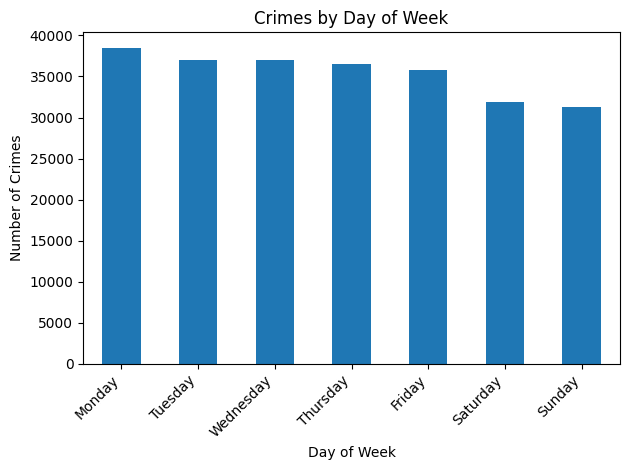

In [7]:
# Crimes by Day of Week
dow_counts = df['DayName'].value_counts().sort_index()
plt.figure()
dow_counts.plot(kind='bar')
plt.xlabel('Day of Week')
plt.xticks(rotation=45, ha="right")
plt.ylabel('Number of Crimes')
plt.title('Crimes by Day of Week')
plt.tight_layout()
plt.show()

- Monday sees the highest volume (~38.5 K), tapering off toward the weekend.

- Sunday has the fewest reported incidents (~31.3 K).

- Suggests weekdays (especially start of week) are busier—perhaps tied to commuting and business hours.

### Monthly Crime Trend

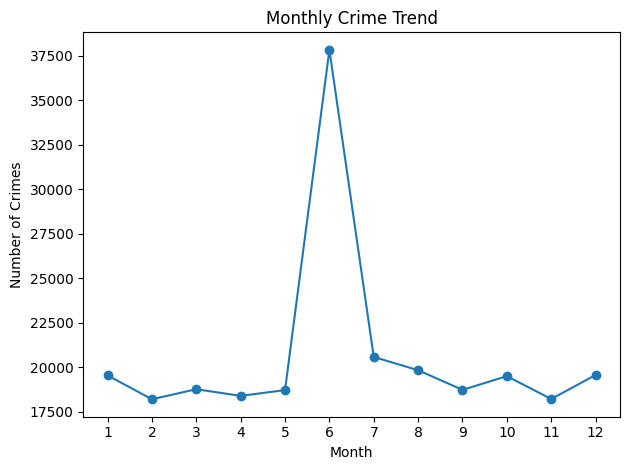

In [8]:
# Monthly Crime Trend
monthly_counts = df['Month'].value_counts().sort_index()
plt.figure()
monthly_counts.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Monthly Crime Trend')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()

- June (Month 6) spikes at 38 K+, well above other months (which average ~19 K).

- Late spring/early summer peak might reflect seasonal factors (longer daylight, tourism).

### Top 10 Crime Types

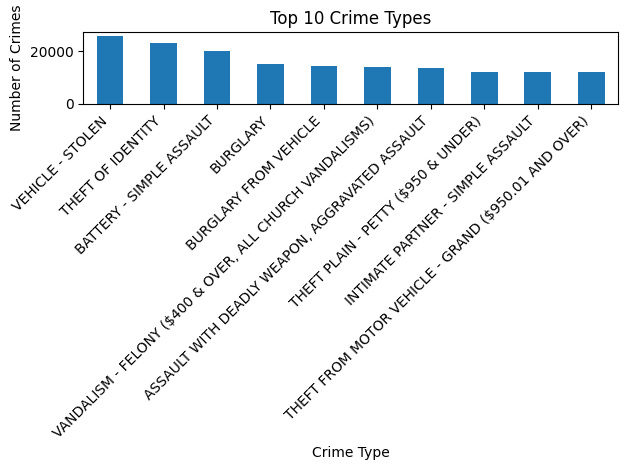

In [9]:
# Top 10 Crime Types
crime_cols = [c for c in df.columns if 'DESC' in c.upper()]
crime_col = crime_cols[0]
top_types = df[crime_col].value_counts().head(10)
plt.figure()
top_types.plot(kind='bar')
plt.xlabel('Crime Type')
plt.ylabel('Number of Crimes')
plt.title('Top 10 Crime Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Vehicle theft (“VEHICLE – STOLEN”) dominates at ~25 K.

- Identity theft and simple assaults also rank highly, each >20 K.

- Resource allocation could focus on high-volume categories.

### Heatmap of Crimes: Day vs Hour

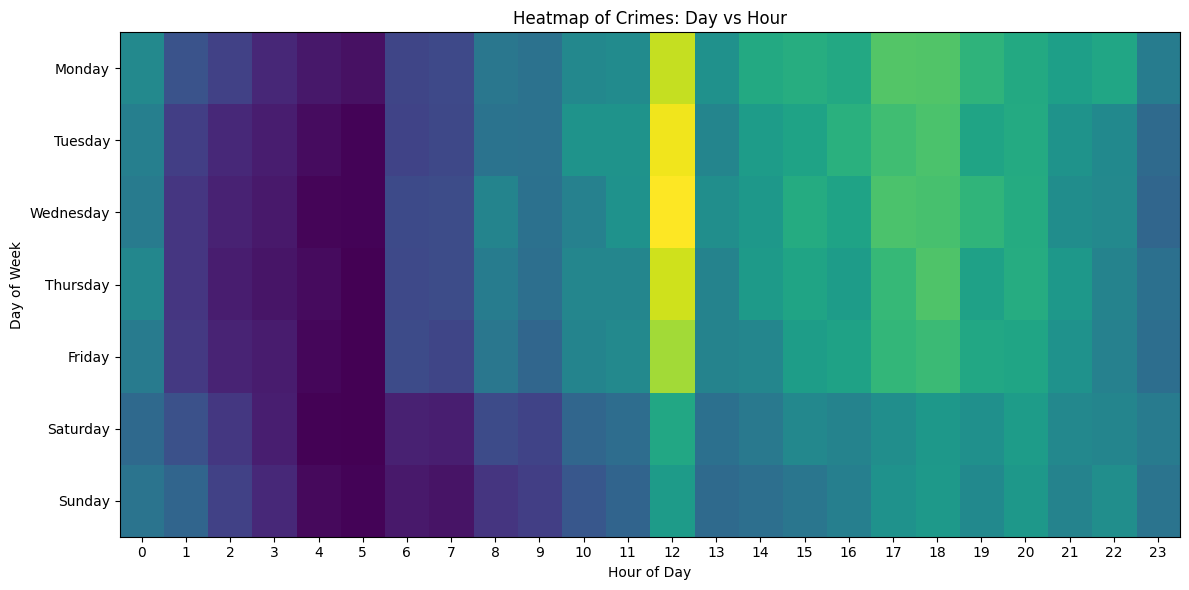

In [10]:
# Heatmap: Day of Week vs. Hour
day_name_list = list(calendar.day_name)

pivot = df.pivot_table(
    index='DayName',
    columns='Hour',
    aggfunc='size',
    fill_value=0,
    observed=False
)

pivot = pivot.reindex(index=day_name_list)

plt.figure(figsize=(12, 6))
plt.imshow(pivot, aspect='auto')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Heatmap of Crimes: Day vs Hour')
plt.yticks(ticks=range(7), labels=day_name_list)
plt.xticks(ticks=range(24), labels=range(24))
plt.tight_layout()
plt.show()

- Across all days, noon (12:00) remains the single busiest hour.

- Evening hours (17:00–20:00) show a secondary rise.

- Overnight (0:00–5:00) stays low except slight upticks Friday/Saturday nights.

In [11]:
# Summary metrics
peak_dow = dow_counts.idxmax()
peak_month = monthly_counts.idxmax()
peak_crime_type = top_types.idxmax()

# Display summary table
summary = pd.DataFrame({
    'Metric': ['Peak Day of Week', 'Peak Month', 'Top Crime Type'],
    'Value': [peak_dow, peak_month, peak_crime_type]
})
print("Summary of Additional Metrics:\n\n", summary)

Summary of Additional Metrics:

              Metric             Value
0  Peak Day of Week            Monday
1        Peak Month                 6
2    Top Crime Type  VEHICLE - STOLEN


## Predictive Modeling

In [12]:
if 'Date' not in df.columns:
    date_col = next(c for c in df.columns if 'DATE' in c.upper())
    time_col = next(c for c in df.columns if 'TIME' in c.upper())
    df['Date'] = pd.to_datetime(df[date_col], errors='coerce')
    df['Hour'] = pd.to_datetime(df[time_col].astype(str).str.zfill(4), format='%H%M', errors='coerce').dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month

# Identify key columns
crime_col = next(c for c in df.columns if 'DESC' in c.upper())
area_col = 'AREA NAME' if 'AREA NAME' in df.columns else next(c for c in df.columns if 'AREA' in c.upper())

### Spatio-Temporal Forecasting

In [ ]:
# Spatio-Temporal Forecasting
daily = df.set_index('Date').resample('D').size().rename('Count').to_frame()
for lag in [1, 7, 14]:
    daily[f'lag_{lag}'] = daily['Count'].shift(lag)
daily.dropna(inplace=True)

train, test = daily.iloc[:-30], daily.iloc[-30:]

rf_reg = RandomForestRegressor(n_estimators=50, random_state=42)
rf_reg.fit(train[[f'lag_{lag}' for lag in [1,7,14]]], train['Count'])

pred = rf_reg.predict(test[[f'lag_{lag}' for lag in [1,7,14]]])
rmse = mean_squared_error(test['Count'], pred)

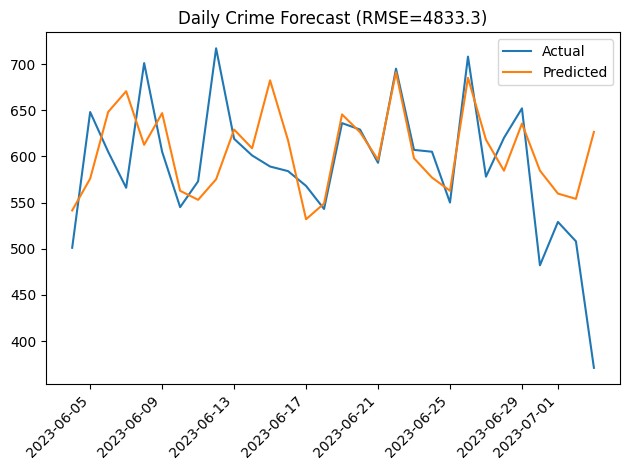

In [13]:
plt.figure()
plt.plot(test.index, test['Count'], label='Actual')
plt.plot(test.index, pred, label='Predicted')
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.title(f'Daily Crime Forecast (RMSE={rmse:.1f})')
plt.tight_layout()
plt.show()

- Model: Random Forest using 1-, 7-, and 14-day lag features.

- Performance: RMSE ≈ 69.5 daily crimes.

- Visual: Overlay of actual vs. predicted counts over the last 30 days.

### Crime-Type Classification

In [14]:
# Crime-Type Classification
top5 = df[crime_col].value_counts().head(5).index
df_cls = df[df[crime_col].isin(top5)].dropna(subset=['Hour','DayOfWeek','Month', area_col])
df_sample = df_cls.sample(n=30000, random_state=42) if len(df_cls)>30000 else df_cls

X = df_sample[['Hour','DayOfWeek','Month', area_col]]
y = df_sample[crime_col]

enc = OneHotEncoder(drop='first', sparse_output=False)
area_enc = enc.fit_transform(X[[area_col]])
X_num = np.hstack([X[['Hour','DayOfWeek','Month']].values, area_enc])
X_tr, X_te, y_tr, y_te = train_test_split(X_num, y, test_size=0.3, stratify=y, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
rf_clf.fit(X_tr, y_tr)

y_pred = rf_clf.predict(X_te)
rep = classification_report(y_te, y_pred, labels=top5, output_dict=True)
print("Classification Report (Top 5):\n\n", pd.DataFrame(rep).transpose())

Classification Report (Top 5):

                           precision    recall  f1-score      support
VEHICLE - STOLEN           0.328942  0.341161  0.334940  2342.000000
THEFT OF IDENTITY          0.441564  0.490789  0.464877  2117.000000
BATTERY - SIMPLE ASSAULT   0.273393  0.262021  0.267586  1851.000000
BURGLARY                   0.241627  0.218615  0.229545  1386.000000
BURGLARY FROM VEHICLE      0.264706  0.241564  0.252606  1304.000000
accuracy                   0.326778  0.326778  0.326778     0.326778
macro avg                  0.310046  0.310830  0.309911  9000.000000
weighted avg               0.321255  0.326778  0.323492  9000.000000


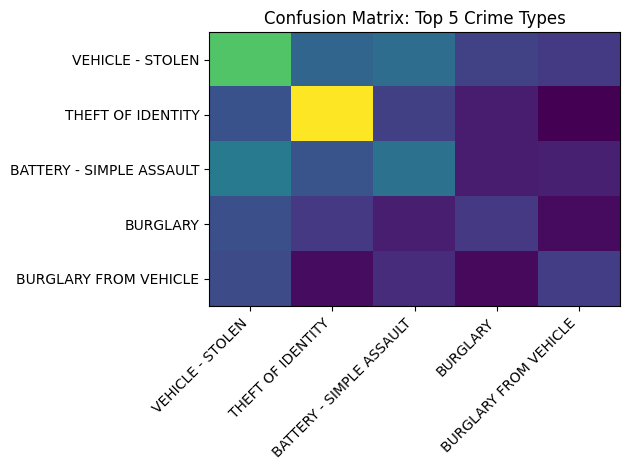

In [15]:
cm = confusion_matrix(y_te, y_pred, labels=top5)
plt.figure()
plt.imshow(cm, aspect='auto')
plt.xticks(range(len(top5)), top5, rotation=45, ha='right')
plt.yticks(range(len(top5)), top5)
plt.title('Confusion Matrix: Top 5 Crime Types')
plt.tight_layout()
plt.show()

- Objective: Predict one of the top 5 crime categories.

- Approach: Random Forest on hour, day, month, and division (sampled 30K records).

- Output: Classification report table (precision/recall/F1) and a confusion‐matrix heatmap showing which categories are most/least confusable.

### Anomaly Detection

In [16]:
# Anomaly Detection
daily_counts = df.set_index('Date').resample('D').size()
mean, std = daily_counts.mean(), daily_counts.std()
anoms = daily_counts[(daily_counts > mean + 3*std) | (daily_counts < mean - 3*std)]
anoms_df = anoms.reset_index()
anoms_df.columns = ['Date','Count']
print("Anomalies Detected:\n\n", anoms_df)

Anomalies Detected:

         Date  Count
0 2023-01-03    891
1 2023-02-02    902
2 2023-02-03    912
3 2023-07-03    371


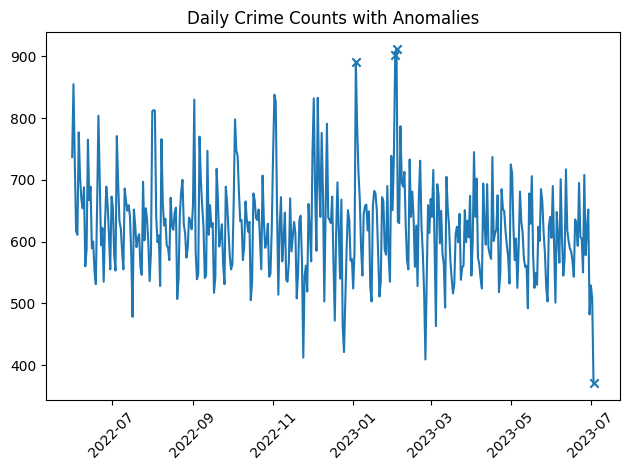

In [17]:
plt.figure()
plt.plot(daily_counts.index, daily_counts)
plt.scatter(anoms.index, anoms.values, marker='x')
plt.xticks(rotation=45)
plt.title('Daily Crime Counts with Anomalies')
plt.tight_layout()
plt.show()

- Method: Z‐score on daily counts (±3σ rule).

- Findings: A small set of days with unusually high or low counts flagged.

- Visual: Time series of daily counts with “×” marking anomalies, plus a table of anomaly dates/counts.